### Exploring Aging Curves using FIFA Player Ratings

The following notebook will show how to construct Aging Curves for soccer players using scores from the series of FIFA games. The dataset is sliced by position and team to demonstrate how players develop depending on these attributes.

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# turn off the SettingWithCopy warning 
pd.options.mode.chained_assignment = None

#### Preparing the dataset

As a first step, let us load the full dataset. It will be helpful to simplify the 'position' column by designating the first position listed as a player's main position.

In [179]:
compressed_fifa_ratings = pd.read_csv('data/compressed_player_rating_dataset.csv', encoding='latin-1')
# compressed_fifa_ratings.set_index('player_url', inplace=True)

parsed_positions = compressed_fifa_ratings['position'].str.split(' ', expand=True)
parsed_positions.columns = ['main_position', 'position_2', 'position_3', 'position_4']
compressed_fifa_ratings = pd.concat([compressed_fifa_ratings, parsed_positions], axis=1)

compressed_fifa_ratings.drop(['Unnamed: 0', 'position'], axis=1, inplace=True)
compressed_fifa_ratings.head(5)

,name,age,overall,potential,team,nationality,rating_date,main_position,position_2,position_3,position_4
0,Patrick Deman,44,52,52,KV Kortrijk,Belgium,10/25/2013,GK,None,None,None
1,Marko Rehmer,34,75,79,Eintracht Frankfurt,Germany,8/30/2006,CB,None,None,None
2,Stijn Stijnen,25,70,78,Club Brugge KV,Serbia,8/30/2006,GK,None,None,None
3,Stijn Stijnen,25,70,78,Club Brugge KV,Belgium,2/22/2007,GK,None,None,None
4,Stijn Stijnen,26,71,73,Club Brugge KV,Belgium,8/30/2007,GK,None,None,None


#### Aging Curves

Now that we have our raw dataset ready to go, let us spend a moment discussing the methodology we will use to produce an 'aging curve'. The preferred method of calculating the aging curve has long been the 'delta method', described by Mitchel Lichtman in the link below:
https://www.fangraphs.com/tht/how-do-baseball-players-age-part-1/

Broadly, the delta method compares how individual players perform in back-to-back years. This information is then aggregated to produce an average change in performance over the course of a typical career.

In [180]:
just_overall_ratings = compressed_fifa_ratings[['name', 'team', 'age', 'main_position', 'overall']].drop_duplicates()
just_overall_ratings['age_next_year'] = just_overall_ratings['age'].apply(lambda x: x+1)
year_over_year_ratings = pd.merge(just_overall_ratings, just_overall_ratings, left_on=['name', 'age_next_year'],
                                  right_on=['name', 'age'], how='left').drop_duplicates()
year_over_year_ratings = year_over_year_ratings[['name', 'main_position_x', 'team_y', 'age_x', 'age_next_year_x', 'overall_x', 'overall_y']]
year_over_year_ratings.columns = ['name', 'main_position', 'team', 'age', 'age_next_year', 'overall', 'next_year_overall']
year_over_year_ratings.dropna(inplace=True)

year_over_year_ratings['diff'] = year_over_year_ratings['next_year_overall'] - year_over_year_ratings['overall']

To begin with, let us create the average aging curve for all the players in our dataset. Not all transitions from one age to the next will be sufficiently represented in our dataset. To begin with, let's establish which ages to use as cutoff points when building our aging curves.

In [181]:
year_over_year_ratings['age_couplet'] = year_over_year_ratings['age'].map(str) + '/' + year_over_year_ratings['age_next_year'].map(str)

avg_rating_changes = year_over_year_ratings.groupby(['age_couplet'], as_index=False)['diff'].count().set_index('age_couplet')
avg_rating_changes

,diff
age_couplet,
14/15,1
15/16,83
16/17,3636
17/18,14941
18/19,29373
19/20,39648
20/21,44156
21/22,45592
22/23,46058


It appears that the number of observations drops quite dramatically for age couplets under 16, and for age couplets over 38. As such, we will build our aging curves for players with ratings between 16 and 38.

As a next step, we can construct our first aging curve for the full population of players in our dataset.

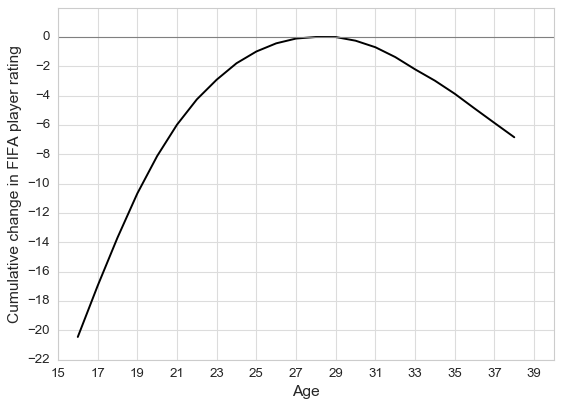

In [182]:
avg_rating_changes = year_over_year_ratings.groupby(['age', 'age_next_year'], as_index=False)['diff'].mean()
avg_rating_changes.columns = ['age', 'age_next_year', 'diff']

avg_rating_changes = avg_rating_changes.loc[(avg_rating_changes['age'] >= 16) & (avg_rating_changes['age'] <= 38)]
avg_rating_changes['cum_sum'] = avg_rating_changes['diff'].cumsum()
maximum_rating = avg_rating_changes['cum_sum'].max()
avg_rating_changes['aging_curve_rating'] = avg_rating_changes['cum_sum'] - maximum_rating

plt.plot(avg_rating_changes['age'], avg_rating_changes['aging_curve_rating'], color='black')
plt.style.use('seaborn-whitegrid')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Cumulative change in FIFA player rating', fontsize=14)
plt.xticks(np.arange(15, 40, 2))
plt.yticks(np.arange(np.round(min(avg_rating_changes['aging_curve_rating']))-2, 2, 2))
plt.ylim(-22, 2)
plt.axhline(0, color='grey', linewidth=1)

plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)

plt.grid(linestyle='-', linewidth=1, color='#DCDCDC')
plt.show()

#### Interpreting Aging Curves

We have constructed these age curves to have the cumulative change in FIFA rating max out at 0. This will simplify our analysis later on when we start comparing positions and individuals. This also allows us to draw the x-axis at the point at which players reach their maximum rating, making it easier to see at which age players peak. 

How should we interpret the y-axis? The cumulative change in FIFA rating is the average total progression that a player makes over the course of their career, starting from when they first become a professional and appear in a FIFA game. 

It would appear that players in FIFA reach their peak performance between ages 28 and 29. The 'peak period' seems to last between ages 27 and 30. It appears that the average player begins their career 20 points below their maximum, and retires roughly 7 points below their peak.


#### Aging Curves by Position

A logical extension of this work is to consider how this aging curve might differ by position. Conventional wisdom dictates that goalkeepers have greater longevity than attacking players. Wingers, who are more reliant on speed than players in central positions, may have lower longevity too (unless your name is Arjen Robben).

As a first step, let's make sure that the sample size for every position is large enough to enable the production of an aging curve - if necessary, we can consolidate similar positions.

In [183]:
all_positions = list(set(year_over_year_ratings['main_position']))

for pos in all_positions:
    one_position_only = year_over_year_ratings.loc[year_over_year_ratings['main_position'] == pos]
    print(pos, one_position_only.shape[0]) 

ST 88353
CM 65531
RW 15005
CDM 40825
RWB 2179
LWB 2321
RB 38663
CF 9981
RM 34599
LF 580
LB 37265
CAM 37796
RF 655
GK 50302
SW 108
LW 13552
CB 86676
LM 34036


It appears that certain positions only contain a few observations. RWB, LF, CF, RF, SW and LWB have very small samples. We will fold these positions in with the most similar position as follows:

CF (Center Forward) --> ST (Striker)
RWB (Right Wing Back) --> RB (Right Back)
LF (Left Forward) --> LW (Left Winger)
RF (Right Forward) --> RW (Right Winger)
SW (Sweeper) --> CB (Center Back)
LWB (Left Wing Back) --> LB (Left Back)

In [184]:
position_mapping = {'CF': 'ST', 'RWB': 'RB', 'LF': 'LW', 'RF': 'RW', 'SW': 'CB', 'LWB': 'LB'}

year_over_year_ratings['edited_position'] = year_over_year_ratings['main_position'].replace(position_mapping)
year_over_year_ratings.head()

,name,main_position,team,age,age_next_year,overall,next_year_overall,diff,age_couplet,edited_position
2,Stijn Stijnen,GK,Club Brugge KV,25,26,70,71.0,1.0,25/26,GK
3,Stijn Stijnen,GK,Club Brugge KV,26,27,71,73.0,2.0,26/27,GK
4,Stijn Stijnen,GK,Club Brugge KV,27,28,73,73.0,0.0,27/28,GK
5,Stijn Stijnen,GK,Club Brugge KV,27,28,73,72.0,-1.0,27/28,GK
6,Stijn Stijnen,GK,Club Brugge KV,28,29,73,73.0,0.0,28/29,GK


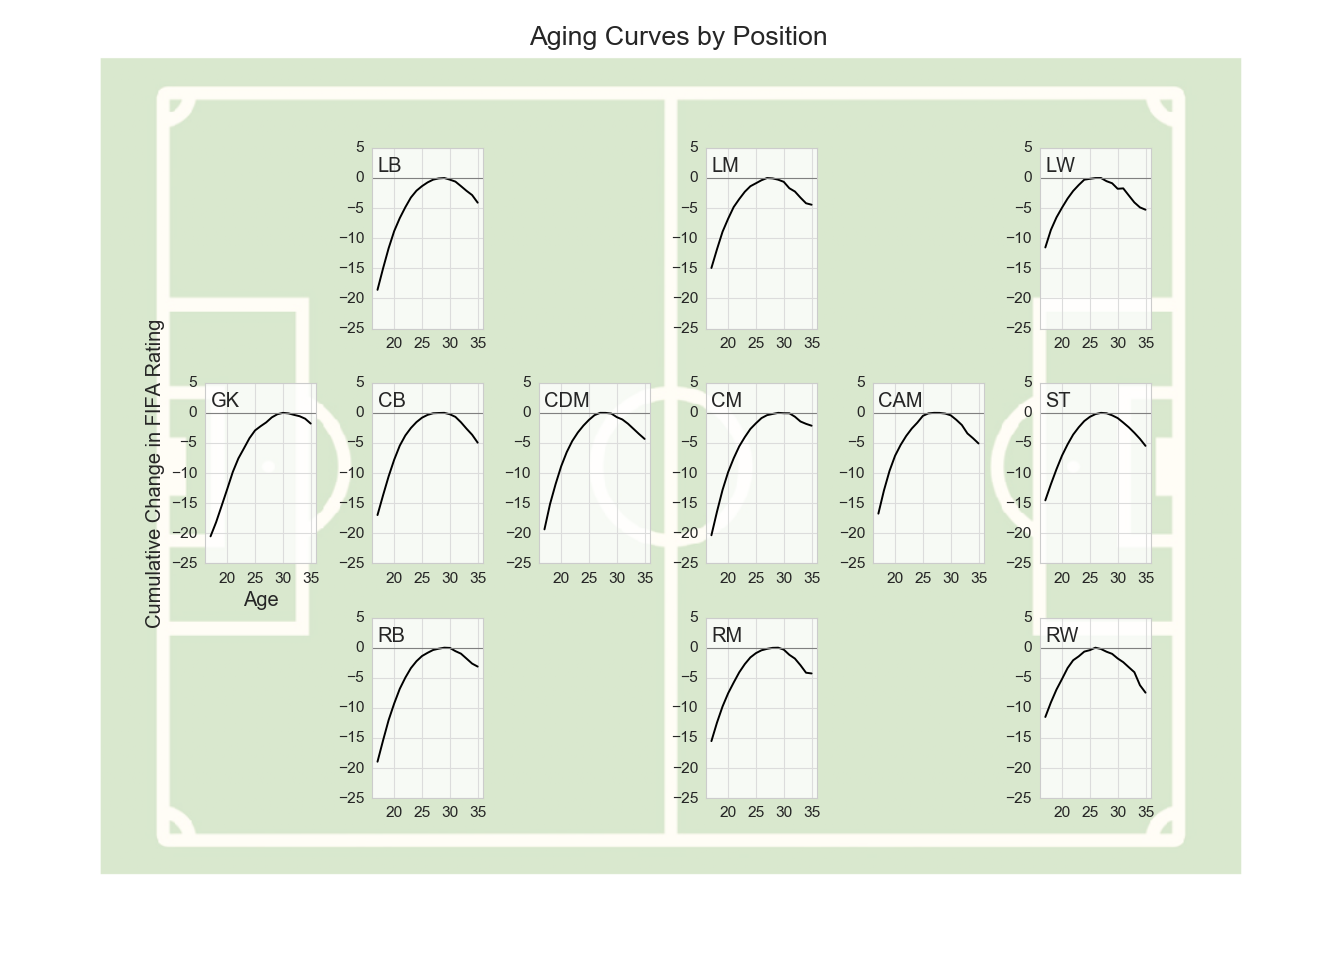

In [185]:
avg_rating_changes = year_over_year_ratings.groupby(['age', 'age_next_year', 'edited_position'], as_index=False)['diff'].mean()
avg_rating_changes.columns = ['age', 'age_next_year', 'edited_position', 'diff']
avg_rating_changes = avg_rating_changes.loc[(avg_rating_changes['age'] >= 17) & (avg_rating_changes['age'] <= 35)]

number_of_rows = 5
number_of_columns = 8
all_positions = {'GK': [number_of_rows, number_of_columns, 18], 
                 'RB': [number_of_rows, number_of_columns, 27], 
                 'CB': [number_of_rows, number_of_columns, 19], 
                 'LB': [number_of_rows, number_of_columns, 11], 
                 'CDM': [number_of_rows, number_of_columns, 20], 
                 'RM': [number_of_rows, number_of_columns, 29], 
                 'CM': [number_of_rows, number_of_columns, 21], 
                 'LM': [number_of_rows, number_of_columns, 13], 
                 'CAM': [number_of_rows, number_of_columns, 22], 
                 'RW': [number_of_rows, number_of_columns, 31], 
                 'ST': [number_of_rows, number_of_columns, 23], 
                 'LW': [number_of_rows, number_of_columns, 15],
                }

fig = plt.figure(figsize=(16, 14))
img = plt.imread("soccer_pitch_border.png")
plt.imshow(img)
plt.axis('off')

for key, value in all_positions.items():
#     print(key, value)
    position = avg_rating_changes.loc[avg_rating_changes['edited_position'] == key]
    position['cum_sum'] = position['diff'].cumsum()
    maximum_cumsum = position['cum_sum'].max()
    position['aging_rating'] = position['cum_sum'] - maximum_cumsum
    
    peak = position.loc[position['aging_rating'] == 0]['age']
    peak = peak.iloc[0]
    
    ax = fig.add_subplot(value[0], value[1], value[2])
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(0.8)
    ax.plot(position['age'], position['aging_rating'], color='black')
    
    ax.text(17, 1, key, fontsize=18)
    
    ax.set_xlim(16, 36)
    ax.set_ylim(-25, 5)
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
    if key == 'GK':
        ax.set_xlabel('Age', fontsize=18)
        ax.set_ylabel('Cumulative Change in FIFA Rating', fontsize=18)
    
    plt.grid(linestyle='-', linewidth=1, color='#DCDCDC')
    plt.axhline(0, color='grey', linewidth=1)


fig.suptitle('Aging Curves by Position', y=0.9, fontsize=24)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.3)
plt.show()

At a glance, we can immediately start to draw some interesting conclusions:

-  Goalkeepers peak later than players in any other position (between ages 29 and 32)
-  Attacking players peak earlier than defensive players - especially wingers
-  Wingers start their careers much closer to their peak than central (and especially defensive) players. This implies that it may be easier to detect talent among wide attacking players than, for instance, goalkeepers

#### Analysis by team

In addition to analyzing aging curves by position, we can also construct average aging curves for various clubs. After all, certain clubs are known for their ability to develop young players, while others are thought to attract players at the peak of their career and invest less in youth development. 

For the purpose of this investigation, let us look at the top six teams from the Premier League: Liverpool, Manchester United, Manchester City, Chelsea, Tottenham Hotspur and Arsenal. These teams have very different reputations in terms of their investment in young vs. more experienced players and should make for an interesting set of clubs to compare.

Text(0.04, 0.5, 'Cumulative Change in FIFA Rating')

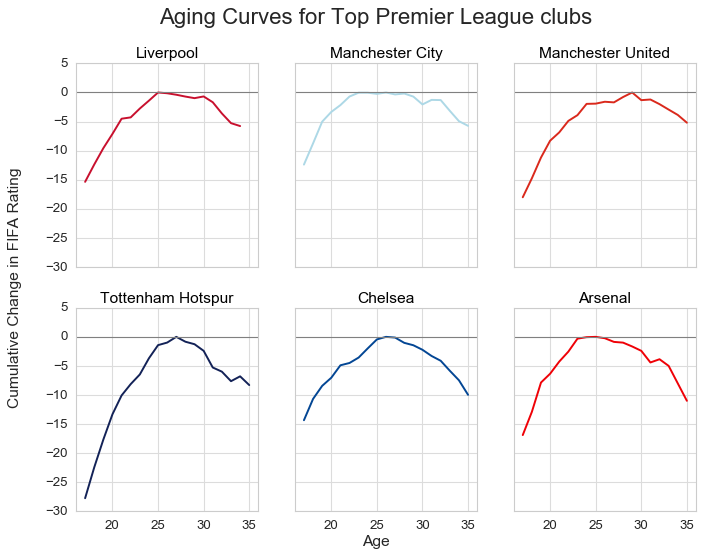

In [186]:
avg_rating_changes_by_team = year_over_year_ratings.groupby(['age', 'age_next_year', 'team'], as_index=False)['diff'].mean()
avg_rating_changes_by_team.columns = ['age', 'age_next_year', 'team', 'diff']
avg_rating_changes_by_team = avg_rating_changes_by_team.loc[(avg_rating_changes_by_team['age'] >= 17) & (avg_rating_changes_by_team['age'] <= 35)]

all_teams = {
                'Liverpool': '#C8102E',
                'Manchester City': '#ADD8E6',
                'Manchester United': '#DA291C',
                'Tottenham Hotspur': '#132257',
                'Chelsea': '#034694',
                'Arsenal': '#EF0107',
}

fig = plt.figure(figsize=(10, 7))

num = 0
for team, color in all_teams.items():
    num += 1
    
    position = avg_rating_changes_by_team.loc[avg_rating_changes_by_team['team'] == team]
    position['cum_sum'] = position['diff'].cumsum()
    maximum_cumsum = position['cum_sum'].max()
    position['aging_rating'] = position['cum_sum'] - maximum_cumsum
    
    ax = fig.add_subplot(2, 3, num)
    ax.patch.set_facecolor('white')
    ax.plot(position['age'], position['aging_rating'], color=color)
       
    ax.set_xlim(16, 36)
    ax.set_ylim(-30, 5)
    
    if num in range(4) :
        plt.tick_params(labelbottom=False)
        
    if num not in [1,4] :
        plt.tick_params(labelleft=False)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    
    plt.axhline(0, color='grey', linewidth=1)
    plt.title(team, fontsize=14, fontweight=0, color='black')
    plt.grid(linestyle='-', linewidth=1, color='#DCDCDC')

fig.suptitle('Aging Curves for Top Premier League clubs', y=1, fontsize=20)
fig.text(0.5, 0.04, 'Age', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Cumulative Change in FIFA Rating', va='center', rotation='vertical', fontsize=14)

It is apparent that the aging curves for the top Premier League clubs look very different. Of the top teams, Tottenham Hotspurs seems to invest most in the development of young players. Talented players get the opportunity to develop themselves, peaking around the age of 27. Manchester United players have a similar aging curve profile as Tottenham Hotspur players - they are given the opportunity to develop from a young age, improving gradually until they peak around 28-29. 

Manchester City players have a very different aging profile. Their players peak, on average, at the age of 23 and remain at a similar level until the age of 27. This is consistent with the reputation of the club, especially in recent years: acquiring world-class players for vast sums of money rather than investing in their youth academy. 

It is also worth spending a moment looking at how the top Premier League clubs differ in terms of how their players decline - Liverpool, Manchester City and Manchester United players appear to decline less from their peak as they age. The average difference between a player's peak and their rating at the age of 35 is about 5 points, versus approximately 10 for the three other clubs. It is not entirely clear what we should attribute this to - perhaps these clubs manage out declining players more actively, or employ older players for positions that decline less with age (defensive positions and goalkeepers). 


#### Top Player Analysis

Let's spend a moment looking at the aging curves for a few top players. One restriction here is that FIFA player rating data is not available for the full duration of the careers of players like Cristiano Ronaldo and Zlatan Ibrahimovic - but let's take a look at a few.

Text(0.04, 0.5, 'Cumulative Change in FIFA Rating')

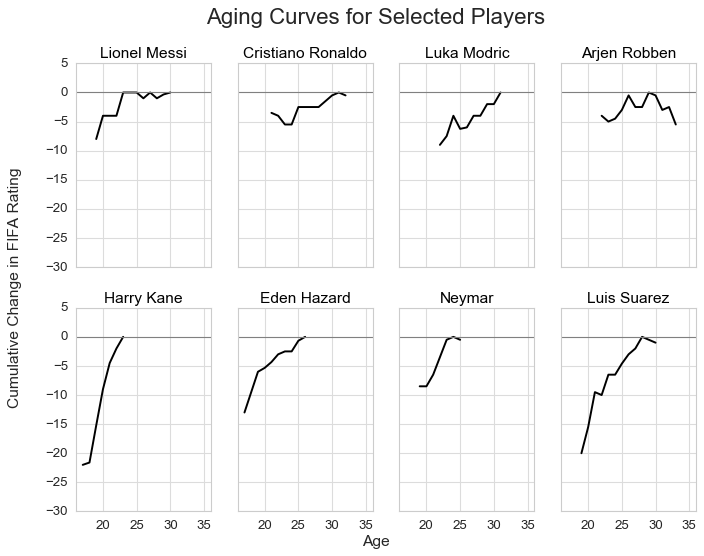

In [189]:
selected_players = ['Lionel Messi', 'Cristiano Ronaldo', 'Luka Modric', 'Arjen Robben', 'Harry Kane', 'Eden Hazard', 'Neymar', 'Luis Suarez']

rating_changes_by_player = year_over_year_ratings.groupby(['age', 'age_next_year', 'name'], as_index=False)['diff'].mean()
rating_changes_by_player.columns = ['age', 'age_next_year', 'name', 'diff']
rating_changes_by_player = rating_changes_by_player.loc[(rating_changes_by_player['age'] >= 17) & (rating_changes_by_player['age'] <= 35)]

fig = plt.figure(figsize=(10, 7))

num = 0
for player in selected_players:
    num += 1
    
    position = rating_changes_by_player.loc[rating_changes_by_player['name'] == player]
    position['cum_sum'] = position['diff'].cumsum()
    maximum_cumsum = position['cum_sum'].max()
    position['aging_rating'] = position['cum_sum'] - maximum_cumsum
    
    ax = fig.add_subplot(2, 4, num)
    ax.patch.set_facecolor('white')
    ax.plot(position['age'], position['aging_rating'], color='black')
       
    ax.set_xlim(16, 36)
    ax.set_ylim(-30, 5)
    
    if num in range(5) :
        plt.tick_params(labelbottom=False)
        
    if num not in [1,5] :
        plt.tick_params(labelleft=False)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    
    plt.axhline(0, color='grey', linewidth=1)
    plt.title(player, fontsize=14, fontweight=0, color='black')
    plt.grid(linestyle='-', linewidth=1, color='#DCDCDC')

fig.suptitle('Aging Curves for Selected Players', y=1, fontsize=20)
fig.text(0.5, 0.04, 'Age', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Cumulative Change in FIFA Rating', va='center', rotation='vertical', fontsize=14)
    

The players outlined above are at various stages of their career and some will likely continue to progress. It is noteworthy that some players were close to what is likely their peak very early on (Messi, Cristiano Ronaldo, Neymar), while other players like Harry Kane and Luis Suarez have had a more gradual development.

#### Conclusion

The aging curves produced in this analysis are entirely reliant on the quality and consistency of FIFA Player ratings. However, in a sport like soccer where it is difficult to quantify the performance of individual players across teams, countries and positions, FIFA ratings may be one of the best ways to produce aging curves. 

For those of you who would like to explore more slices of the aging curve dataset, the Github repo for this project also contains an interactive visualization tool that allows for the easy generation and comparison of aging curves. Alternatively, you can also use this link: https://mybinder.org/v2/gh/RoaldSchuring/Modeling-Football-Aging-Curves/c1f6fcde2ac6a20a4751e874ef8ebb1b8ba252c1?filepath=aging_curves_interactive_visualization